In [ ]:
# Module: python3/3.11.7 
# Environment base: /g/data/xe2/datasets/Environments/paddockenv3_11
# Not using geospatenv because it doesn't have pysheds installed

In [1]:
# Standard library
import os
import pickle

# Dependencies
import numpy as np
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
from dea_tools.plotting import rgb

# Local imports
os.chdir(os.path.join(os.path.expanduser('~'), "Projects/PaddockTS"))
from DAESIM_preprocess.util import gdata_dir, scratch_dir, visualise_tif_rioxarray, plot_time_series, plot_time_point
from DAESIM_preprocess.topography import show_acc, show_aspect, show_slope, show_ridge_gullies, pysheds_accumulation, catchment_gullies, catchment_ridges, calculate_slope
from DAESIM_preprocess.canopy_height import visualise_canopy_height
from DAESIM_preprocess.sentinel import available_imagery_sentinel, calendar_plot_sentinel, time_lapse

In [52]:
stubs = {
    "MULL": "Mulloon",
    "CRGM": "Craig Moritz Farm",
    "MILG": "Milgadara",
    "ARBO": "Arboreturm",
    "KOWN": "Kowen Forest",
    "ADAM": "Canowindra"
}

In [62]:
# Filepaths
outdir = os.path.join(gdata_dir, "Data/PadSeg/")
visuals_dir = os.path.join(scratch_dir, "Visuals")
stub = "MULL"

In [4]:
%%time
# Calculate the terrain data
filename = os.path.join(outdir, f"{stub}_terrain.tif")
grid, dem, fdir, acc = pysheds_accumulation(filename)
num_catchments = 20
gullies, full_branches = catchment_gullies(grid, fdir, acc, num_catchments)
ridges = catchment_ridges(grid, fdir, acc, full_branches)
slope = calculate_slope(filename)

CPU times: user 20.5 s, sys: 9.86 s, total: 30.3 s
Wall time: 25.2 s


In [ ]:
%%time
show_ridge_gullies(dem, ridges, gullies, visuals_dir, stub)

show_acc(acc, visuals_dir, stub)

show_aspect(fdir, visuals_dir, stub)

show_slope(slope, visuals_dir, stub) 

visualise_canopy_height(filename, visuals_dir, stub)

In [24]:
# Load the sentinel imagery
filename = os.path.join(outdir, f"{stub}_ds2.pkl")
with open(filename, 'rb') as file:
    ds = pickle.load(file)

In [3]:
# Available imagery
available_imagery_sentinel(ds, visuals_dir, stub)

# Calendar plot thumbnail
calendar_plot_sentinel(ds, visuals_dir, stub)

# Calendar plot detailed
calendar_plot_sentinel(ds, size=5, visuals_dir, stub)

# Video
time_lapse(ds, visuals_dir, stub)

In [67]:
def merge_ozwald_silo(ds_ozwald, ds_silo):

    # Find the maximum and minimum soil moisture to see some variation
    ssoil_sum = ds_ozwald['Ssoil'].sum(dim='time')
    
    max_row = int(ssoil_sum.argmax() // ssoil_sum.shape[0])
    max_col = int(ssoil_sum.argmax() % ssoil_sum.shape[0])
    min_row = int(ssoil_sum.argmin() // ssoil_sum.shape[0])
    min_col = int(ssoil_sum.argmin() % ssoil_sum.shape[0])
    
    ssoil_maxpoint = ds_ozwald.isel(longitude=max_row, latitude=max_col)
    ssoil_minpoint = ds_ozwald.isel(longitude=min_row, latitude=min_col)
    
    ssoil_maxpoint = ssoil_maxpoint.rename({'Ssoil': 'Maximum Soil Moisture'})
    ssoil_minpoint = ssoil_minpoint.rename({'Ssoil': 'Minimum Soil Moisture'})
    
    # Making the assumption that the four 5km SILO pixels are similar, so just choosing the first one. Later will want to be more precise using ANU Climate at 1km resolution. 
    ds_silo_point = ds_silo.isel(lat=0, lon=0)
    
    # Combine the datasets along the time dimension
    ds_merged = xr.merge([ds_silo_point, ssoil_maxpoint, ssoil_minpoint], compat='override')
    df = ds_merged.to_dataframe().reset_index()
    df = df.drop(columns=["lat", "lon", "crs", "latitude", "longitude"])
    df = df.set_index('time')
    
    # Rename the columns 
    abbreviations = {
        "daily_rain" : "Rainfall",
        "max_temp" : "Maximum temperature",
        "min_temp" : "Minimum temperature",
        "et_morton_actual": "Actual Evapotranspiration",
        "et_morton_potential":"Potential Evapotranspiration"
        }
    df.rename(columns=abbreviations, inplace=True)
    df.rename_axis("date", inplace=True)

    return df
    

In [90]:
def resample_weekly(df):
    weekly_df = df.resample('W').agg({
        "Rainfall":"sum",
        "Maximum temperature": "mean",
        "Minimum temperature": "mean",
        "Maximum Soil Moisture": "mean",
        "Minimum Soil Moisture": "mean",
        "Actual Evapotranspiration": "sum",
        "Potential Evapotranspiration": "sum"
    })
    weekly_df = weekly_df.interpolate('linear')
    
    # We don't have soil moisture data for 2024 right now
    weekly_df.loc[weekly_df.index > '2024-01-01', 'Maximum Soil Moisture'] = np.nan
    weekly_df.loc[weekly_df.index > '2024-01-01', 'Minimum Soil Moisture'] = np.nan

    return weekly_df

In [97]:
def visualise_water(df, title="", outdir=scratch_dir, stub="Test"):
    # Rainfall, evapotranspiration, soil moisture plot
    plt.figure(figsize=(50, 20))
    
    # Plot the data
    rainfall_plot = plt.bar(df.index, df['Rainfall'], color='skyblue', width=5)
    et_actual_plot = plt.bar(df.index, df['Potential Evapotranspiration'], color='orange')
    et_potential_plot = plt.plot(df.index, df['Actual Evapotranspiration'], color='green')
    moisture_max_plot = plt.plot(df.index, df['Maximum Soil Moisture']/10, color='darkorchid')
    moisture_min_plot = plt.plot(df.index, df['Minimum Soil Moisture']/10, color='blue')
    
    # Adjust the size of the tick labels on the x-axis and y-axis
    plt.xticks(fontsize=20)  
    plt.yticks(fontsize=20)  
    
    # Reorder the legend items
    handles = [rainfall_plot, et_actual_plot[0], et_potential_plot[0], moisture_max_plot[0], moisture_min_plot[0]]
    labels = ['Total Rainfall (mm)', "Potential Evapotranspiration (mm)", "Actual Evapotranspiration (mm)", "Maximum Soil Moisture (mm/10)", "Minimum Soil Moisture (mm/10)"]
    plt.legend(handles=handles, labels=labels, fontsize=30, loc='upper left')
    plt.title(title, fontsize=50)
    
    plt.tight_layout()
    
    filename = os.path.join(outdir, f"{stub}_weather.png")
    plt.savefig(filename)
    plt.show()
    print("Saved", filename)


In [95]:
def visualise_temp(df, title="", outpath=scratch_dir, stub="Test"):
    plt.figure(figsize=(50, 10))
    maxtemp_plot = plt.plot(df.index, df["Maximum temperature"], color='red')
    mintemp_plot = plt.plot(df.index, df["Minimum temperature"], color='blue')
    plt.xticks(fontsize=20)  
    plt.yticks(fontsize=20)  
    handles = [maxtemp_plot[0], mintemp_plot[0]]
    labels = ['Maximum Temperature (°C)', 'Minimum Temperature (°C)']
    plt.legend(handles=handles, labels=labels, fontsize=30, loc='upper left')
    plt.title(title, fontsize=50)
    plt.tight_layout()
    
    filename = os.path.join(outpath, f"{stub}_temperature.png")
    plt.savefig(filename)
    plt.show()
    print(filename)

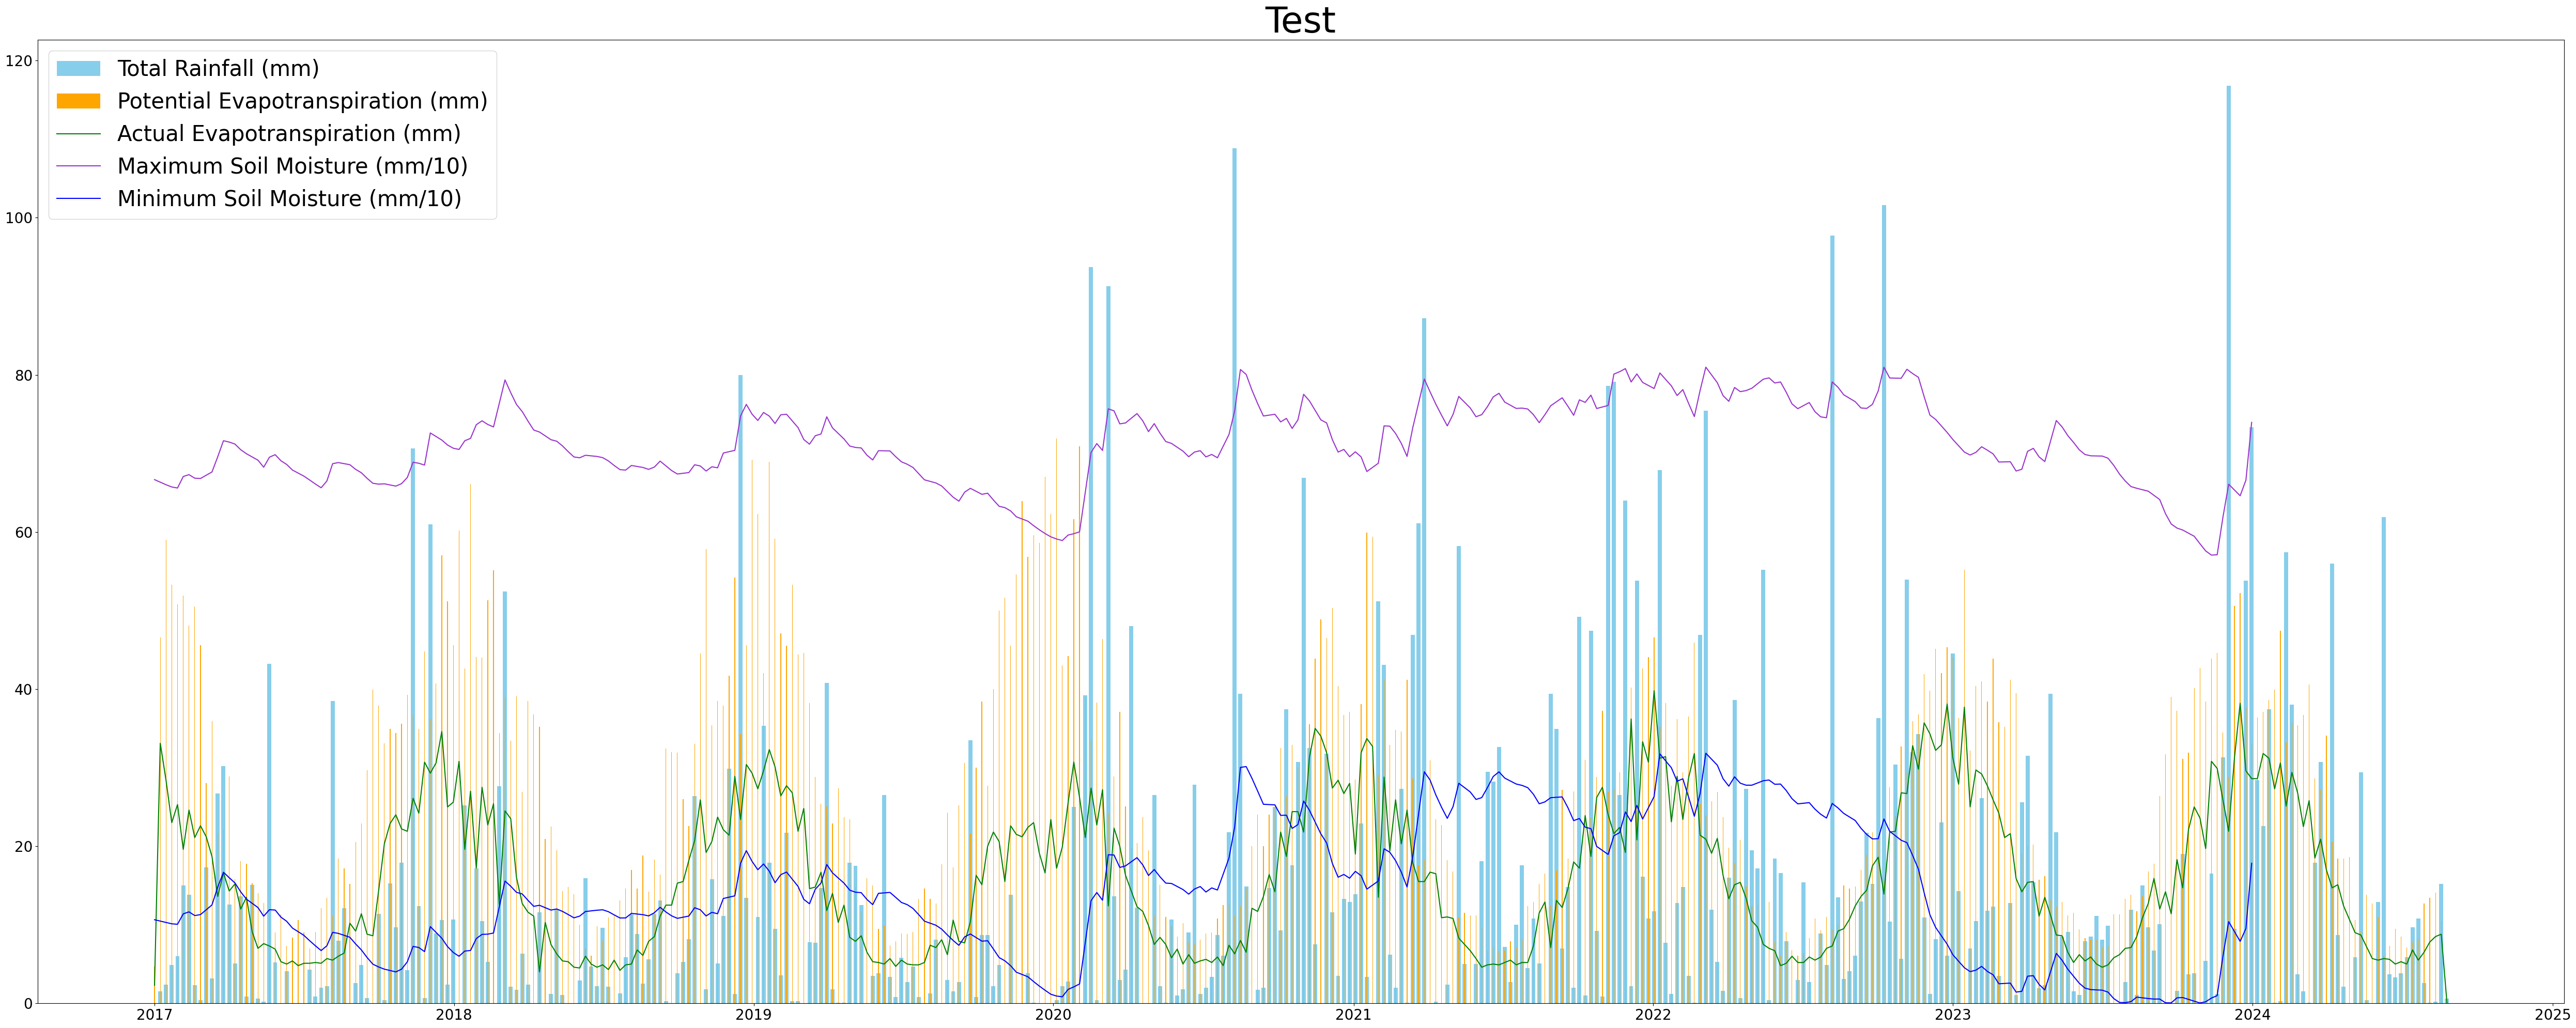

Saved /scratch/xe2/cb8590/Test_weather.png


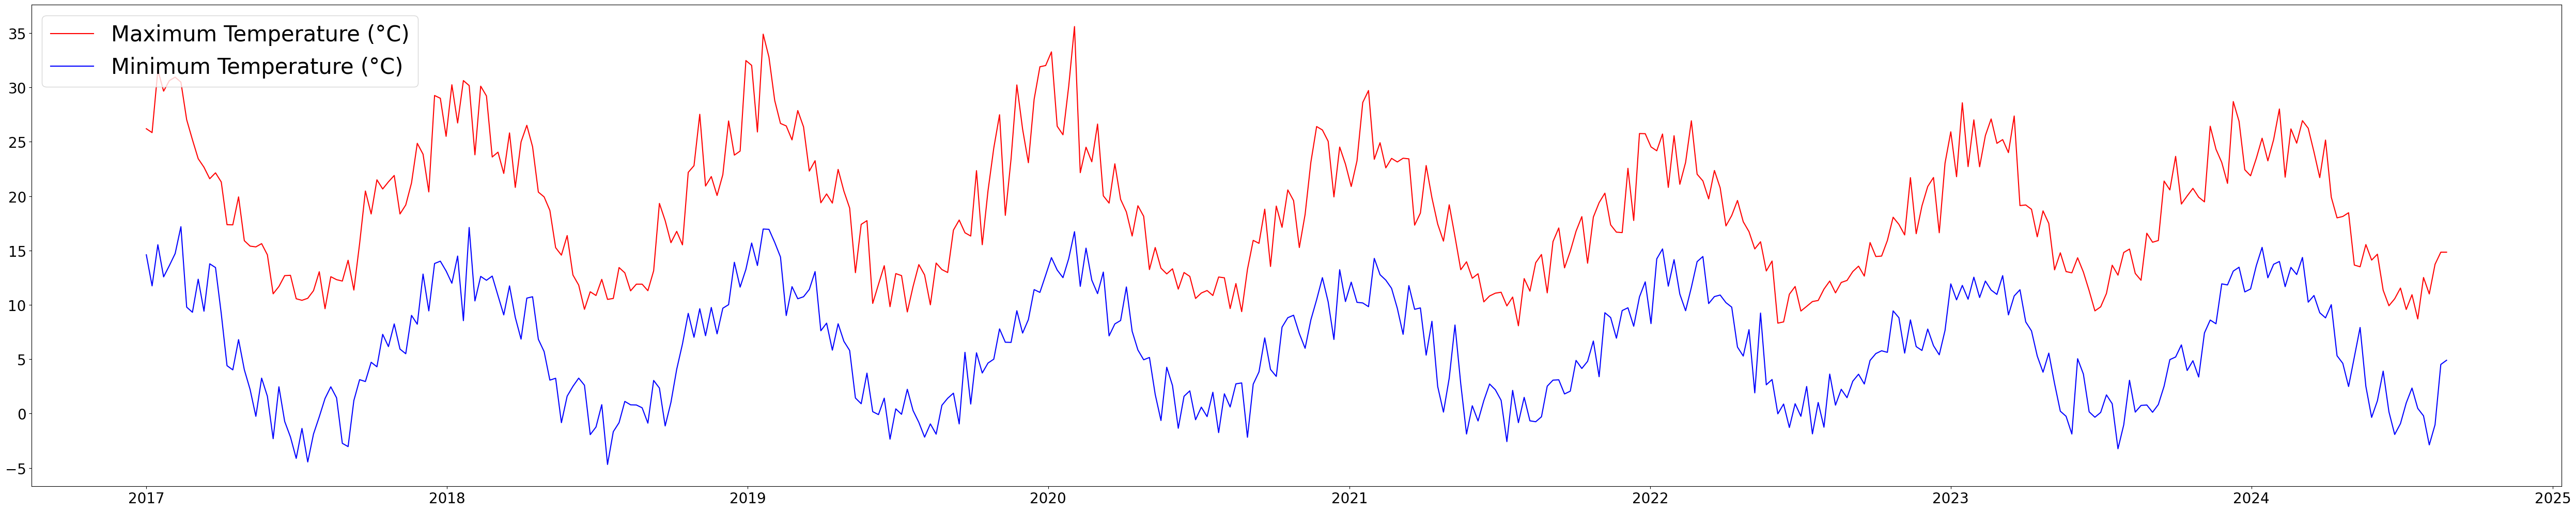

/scratch/xe2/cb8590/Test_temperature.png


In [96]:
# Climate
filename = os.path.join(outdir, f"{stub}_ozwald_8day.nc")
ds_ozwald = xr.open_dataset(filename)

filename = os.path.join(outdir, f"{stub}_silo_daily.nc")
ds_silo = xr.open_dataset(filename)

df = merge_ozwald_silo(ds_ozwald, ds_silo)
df_weekly = resample_weekly(df)

visualise_water(df_weekly)

visualise_temp(df_weekly)

In [58]:
for stub in stubs:
    # Load the sand, silt and clay layers
    filename_sand = os.path.join(outdir, f"{stub}_Sand.tif")
    filename_silt = os.path.join(outdir, f"{stub}_Silt.tif")
    filename_clay = os.path.join(outdir, f"{stub}_Clay.tif")
                            
    ds_sand = rxr.open_rasterio(filename_sand)
    ds_silt = rxr.open_rasterio(filename_silt)
    ds_clay = rxr.open_rasterio(filename_clay)
    
    sand_array = ds_sand.isel(band=0).values
    silt_array = ds_silt.isel(band=0).values
    clay_array = ds_clay.isel(band=0).values
    
    # Rescale values to add up to 100 (range was 74%-108% in Mullon example)
    total_percent = sand_array + silt_array + clay_array
    sand_percent = (sand_array / total_percent) * 100
    silt_percent = (silt_array / total_percent) * 100
    clay_percent = (clay_array / total_percent) * 100

    # Assign soil texture categories
    soil_texture = np.empty(sand_array.shape, dtype=object)
    
    # Fudged the boundaries between sand, loamy sand, and sandy loam, but the rest of these values match the soil texture triangle exactly
    soil_texture[(clay_array < 20) & (silt_array < 50)] = 'Sandy Loam'      # Sandy Loam needs to come before Loam
    soil_texture[(sand_array >= 70) & (clay_array < 15)] = 'Loamy Sand'     # Loamy Sand needs to come from Sand
    soil_texture[(sand_array >= 85) & (clay_array < 10)] = 'Sand'
    soil_texture[(clay_array < 30) & (silt_array >= 50)] = 'Silt Loam'     # Silt Loam needs to come before Silt
    soil_texture[(clay_array < 15) & (silt_array >= 80)] = 'Silt'
    soil_texture[(clay_array >= 27) & (clay_array < 40) & (sand_array < 20)] = 'Silty Clay Loam'
    soil_texture[(clay_array >= 40) & (silt_array >= 40)] = 'Silty Clay'
    soil_texture[(clay_array >= 40) & (silt_array < 40) & (sand_array < 45)] = 'Clay'
    soil_texture[(clay_array >= 35) & (sand_array >= 45)] = 'Sandy Clay'
    soil_texture[(clay_array >= 27) & (clay_array < 40) & (sand_array >= 20) & (sand_array < 45) ] = 'Clay Loam'
    soil_texture[(clay_array >= 20) & (clay_array < 35) & (sand_array >= 45) & (silt_array < 28)] = 'Sandy Clay Loam'
    soil_texture[(clay_array >= 15) & (clay_array < 27) & (silt_array >= 28) & (silt_array < 50) & (sand_array < 53)] = 'Loam'
    
    print(np.unique(soil_texture))

['Sandy Clay Loam' 'Sandy Loam']
['Loamy Sand' 'Sandy Clay Loam' 'Sandy Loam']
['Loamy Sand' 'Sandy Clay Loam' 'Sandy Loam']
['Sandy Clay Loam' 'Sandy Loam']
['Sandy Clay Loam' 'Sandy Loam']
['Clay' 'Clay Loam' 'Sandy Clay' 'Sandy Clay Loam' 'Sandy Loam']


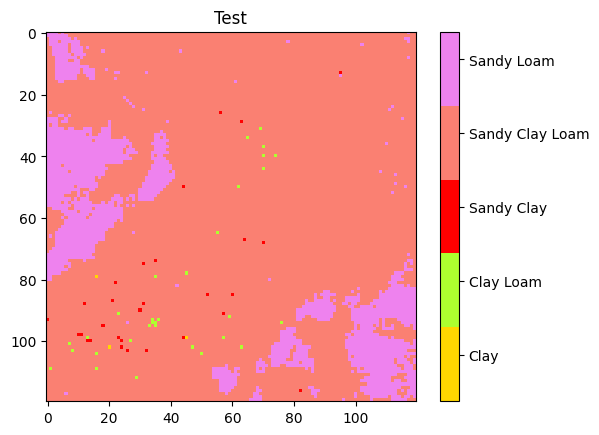

In [61]:
colour_dict = {
    'Sandy Loam': "violet",
    'Loamy Sand': "lightpink",
    'Sand': "orange",
    'Silt Loam': "yellowgreen",
    'Silt': "limegreen",
    'Silty Clay Loam': "lightseagreen",
    'Silty Clay': "turquoise",
    'Clay': "gold",
    'Sandy Clay': "red",
    'Clay Loam': "greenyellow",
    'Sandy Clay Loam': "salmon",
    'Loam':"chocolate"
}

plot_categorical(soil_texture, colour_dict)

In [63]:
filename = os.path.join(outdir, f"{stub}_Sand.tif")
ds_pH = rxr.open_rasterio(filename_sand)

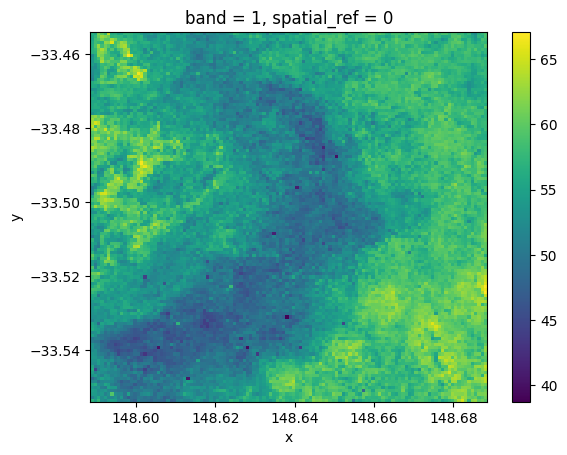

In [64]:
ds_pH.plot()

In [ ]:
# Later also want to visualise:

# Most recent good satellite imagery

# # Paddock boundaries
# filename = os.path.join(outdir, f"{stub}_segment.tif")
# ds = rxr.open_rasterio(filename)
# ds.plot()

# False colour NDWI fourier transform
# filename = os.path.join(outdir, f"{stub}.tif")
# ds = rxr.open_rasterio(filename)
# rgb_array = ds.transpose('y', 'x', 'band') / 255.0
# plt.imshow(rgb_array)

# NDVI calendar plot and paddock heatmap
# Fractional cover calendar plot and paddock heatmap
# Property boundaries